# Lending Club Loan Data Modeling

In this section we will attempt to determine the best model to predict whether or not a borrower will default in the Lending Club Loan data.

Before beginning, we'll define our **_Satisficing_** and **_Optimizing_** metrics. These are defined by Andrew Ng in the _deeplearning.ai_ course named _Structuring Machine Learning Projects_.

After, we'll get down and dirty with some data cleaning to get this dataset in tip-top shape and ready to be modeled.

We then start the modeling, beginning with a **_Logistic Regresion_** model, using **_Forward Selection_** to determine the features. We will then try a **_Support Vector Machine_**, **_Decision Tree_** and **_Random Forest_**. 

After we'll wrap it all up with a summary of what we have learned.

First though, let's do our usual import of a billions packages so we're ready to machine learn.

In [52]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import mcnulty_util as mcu

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Project Goals

## Data Cleaning

In [28]:
df = mcu.mcnulty_preprocessing()

Initiating MAXIMUM data munging power


NameError: name 'np' is not defined

# Single Feature Logistic Regressions

In [4]:
independents = [
    ['dti'],
    ['int_rate'],
    ['annual_inc'],
    ['loan_amnt'],
    ['revol_bal'],
    ['term'],
    ['delinq_2yrs'],
    ['home_ownership'],
    ['grade'],
    ['purpose'],
    ['emp_length']]
dependent = 'default'

In [6]:
results = list()
for variable in independents:
    X, y = df.loc[:, variable], df.loc[:, dependent]
    clf = LogisticRegression(solver='lbfgs')
    if X.iloc[:, 0].dtype not in [np.float64, np.int64]:
        enc = OneHotEncoder()
        X = enc.fit_transform(X)
        log_clf_model(results, clf, 'Logistic Regression', X, y, variable)
    else:
        for degree in range(1, 4):
            if degree == 1:
                clf = LogisticRegression(solver='lbfgs')
                log_clf_model(results, clf, 'Logistic Regression', X, y, variable)
            else:
                clf = Pipeline([('poly', PolynomialFeatures(degree)), 
                                ('clf', LogisticRegression(solver='lbfgs'))])
                log_clf_model(results, clf, 'Logistic Regression', X, y, variable, degree)
# Let's also add a bias model
X = np.ones((df.shape[0], 1))
y = df.loc[:, dependent]
clf = LogisticRegression(solver='lbfgs')
log_clf_model(results, clf, 'Logistic Regression', X, y, 'bias')
(results_to_df(results)
 .pipe(scores_formatted))

,model_type,features,degree,train_accuracy,test_accuracy,precision,recall,f1_score,true_negatives,false_positives,false_negatives,true_positives
4,Logistic Regression,[int_rate],2,78.16%,78.16%,55.56%,0.04%,0.09%,"41,541",4,"11,606",5
0,Logistic Regression,[dti],1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
1,Logistic Regression,[dti],2,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
22,Logistic Regression,[emp_length],1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
21,Logistic Regression,[purpose],1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
20,Logistic Regression,[grade],1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
19,Logistic Regression,[home_ownership],1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
18,Logistic Regression,[delinq_2yrs],3,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
17,Logistic Regression,[delinq_2yrs],2,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0
15,Logistic Regression,[term],1,78.16%,78.16%,0.00%,0.00%,0.00%,"41,545",0,"11,611",0


We can see that all our models except 2 are guess 100 percent non-default. This is common with imbalanced classes. We are basically dealing with a high-bias problem here. We need to add features to **_reduce bias_** and **_add variance_**.

We'll start slow by adding only one additional feature.

# Logistic Regression with Two Features and Polynomials

In [42]:
dependent = 'default'

In [8]:
results = list()
for features_tuple in itertools.combinations(list(independents.keys()), 2):
    features = list(features_tuple)
    if independents[features[0]] == 'dummy' and independents[features[1]] == 'dummy':
        clf = LogisticRegression(solver='lbfgs')
        pipeline = clf_pipeline(clf, features, degree)
        log_clf_model(results, pipeline, 'Logistic Regression', df, y, features, 1)
    else: 
        for degree in range(1, 4):
            clf = LogisticRegression(solver='lbfgs')
            pipeline = clf_pipeline(clf, features, degree)
            log_clf_model(results, pipeline, 'Logistic Regression', df, y, features, degree)
# Let's also add a bias model
X = np.ones((df.shape[0], 1))
y = df.loc[:, dependent]
clf = LogisticRegression(solver='lbfgs')
log_clf_model(results, clf, 'Logistic Regression', X, y, 'bias')
(results_to_df(results)
 .pipe(scores_formatted)
 .head(10))

NameError: name 'itertools' is not defined

In [ ]:
for features_tuple in itertools.combinations(list(independents.keys()), 3):
    features = list(features_tuple)
    if (    independents[features[0]] == 'dummy'
        and independents[features[1]] == 'dummy'
        and independents[features[2]] == 'dummy'):
        clf = LogisticRegression(solver='lbfgs')
        pipeline = clf_pipeline(clf, features, degree)
        log_clf_model(results, pipeline, 'Logistic Regression', df, y, features, 1)
    else: 
        for degree in range(1, 4):
            clf = LogisticRegression(solver='lbfgs')
            pipeline = clf_pipeline(clf, features, degree)
            log_clf_model(results, pipeline, 'Logistic Regression', df, y, features, degree)
(results_to_df(results)
 .pipe(scores_formatted)
 .head(15))

In [ ]:
list(set(unpack_list(results_to_df(results)
         .pipe(scores_formatted)
         .head(15)
         .features.tolist())))

## Visualization of Best Model

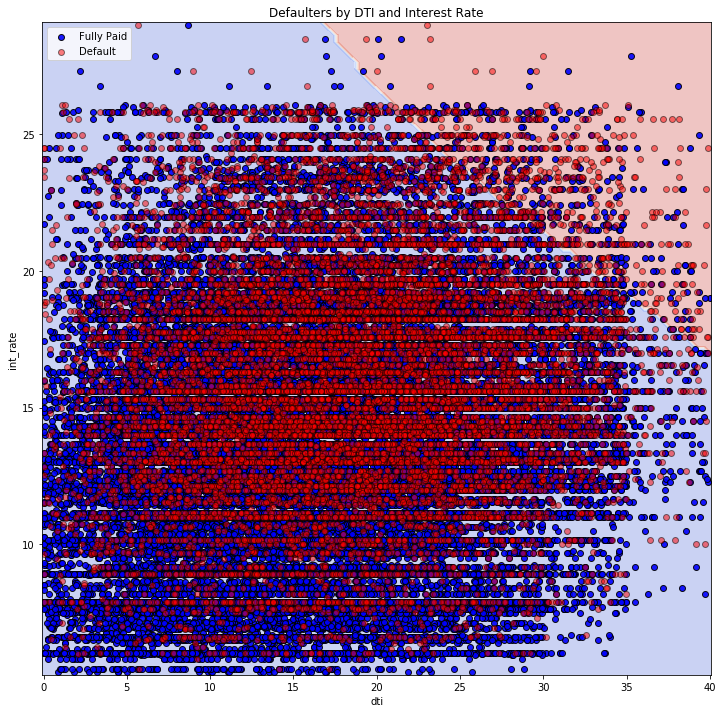

In [42]:
features = ['dti', 'int_rate']
dependent = 'default'
X, y = df.loc[:, features], df.loc[:, dependent]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11,
                                                    stratify=y)
degree = 2
clf = mcu.clf_pipeline(LogisticRegression(), features, degree)
clf.fit(X_train, y_train)
ax = mcu.plot_estimator(clf, X_test,y_test)
ax.set(title='Defaulters by DTI and Interest Rate')
plt.show()

It's not great, but our classifer is definitely telling us people with higher Debt-to-Income Ratios and higher Interest Rates are more likely to default, which makes sense. We can tell from this that the data doesn't provide us with a clean split unfortunately.

## Grid Search with Class Weights

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
features = ['dti', 'int_rate', 'emp_length', 'home_ownership', 'purpose',
            'delinq_2yrs','revol_bal', 'loan_amnt', 'grade', 'term']
degree = 2
X, y = df.loc[:, features], df.loc[:, dependent]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11,
                                                    stratify=y)
pipeline = clf_pipeline(LogisticRegression(), features, degree)
weight_space = np.linspace(0.05, 0.95, 20)
class_weights = [{0: x, 1: 1.0-x} for x in weight_space]
hyperparameters = dict(clf__class_weight=class_weights)
gs = GridSearchCV(pipeline, hyperparameters, scoring='f1', cv=5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('union',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('numeric',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('selector',
                                                                                         ItemSelector(key=['dti',
                                                                                                           'int_rate',
                                                                                                           'delinq_2yrs',
                                                                                                           'revol_bal',
                                   

In [22]:
print("Best Class Weights : {}".format(pd.DataFramegs.best_params_))

Best parameters : {'clf__class_weight': {0: 0.23947368421052628, 1: 0.7605263157894737}}


In [31]:
results = list()

In [32]:
#class_weight = gs.best_params_['clf__class_weight']
features = ['dti', 'int_rate', 'emp_length', 'home_ownership', 'purpose',
            'delinq_2yrs','revol_bal', 'loan_amnt', 'grade', 'term']
class_weight = {0: 0.23947368421052628, 1: 0.7605263157894737}
logr = LogisticRegression(class_weight=class_weight)
X, y = df.loc[:, features], df.loc[:, dependent]
pipeline = clf_pipeline(logr, features, degree)
log_clf_model(results, pipeline, 'Logistic Regression with Class Weights', X, y, features, degree=degree)

,model_type,features,degree,train_accuracy,test_accuracy,precision,recall,f1_score,true_negatives,false_positives,false_negatives,true_positives
0,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term]",3,35.91%,36.02%,22.38%,78.12%,34.79%,"10,079","31,466","2,541","9,070"


In [33]:
degree = 2
features = ['dti', 'int_rate', 'emp_length', 'home_ownership', 'purpose',
            'delinq_2yrs','revol_bal', 'loan_amnt', 'grade', 'term', 'installment']
class_weight = {0: 0.23947368421052628, 1: 0.7605263157894737}
logr = LogisticRegression(class_weight=class_weight)
X, y = df.loc[:, features], df.loc[:, dependent]
pipeline = clf_pipeline(logr, features, degree)
log_clf_model(results, pipeline, 'Logistic Regression with Class Weights', X, y, features, degree=degree)

In [34]:
degree = 3
features = ['dti', 'int_rate', 'emp_length', 'home_ownership', 'purpose',
            'delinq_2yrs','revol_bal', 'loan_amnt', 'grade', 'term', 'installment']
class_weight = {0: 0.23947368421052628, 1: 0.7605263157894737}
logr = LogisticRegression(class_weight=class_weight)
X, y = df.loc[:, features], df.loc[:, dependent]
pipeline = clf_pipeline(logr, features, degree)
log_clf_model(results, pipeline, 'Logistic Regression with Class Weights', X, y, features, degree=degree)

In [43]:
degree = 3
features = ['dti', 'int_rate', 'emp_length', 'home_ownership', 'purpose',
            'delinq_2yrs','revol_bal', 'loan_amnt', 'grade', 'term', 'installment',
            'addr_state']
class_weight = {0: 0.23947368421052628, 1: 0.7605263157894737}
logr = LogisticRegression(class_weight=class_weight)
X, y = df.loc[:, features], df.loc[:, dependent]
pipeline = clf_pipeline(logr, features, degree)
log_clf_model(results, pipeline, 'Logistic Regression with Class Weights', X, y, features, degree=degree)

In [44]:
(results_to_df(results)
 .pipe(scores_formatted)
 .head(10))

,model_type,features,degree,train_accuracy,test_accuracy,precision,recall,f1_score,true_negatives,false_positives,false_negatives,true_positives
0,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term]",3,35.91%,36.02%,22.38%,78.12%,34.79%,"10,079","31,466","2,541","9,070"
1,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term, ...",2,33.59%,33.98%,23.55%,90.02%,37.33%,"7,610","33,935","1,159","10,452"
2,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term, ...",3,31.37%,31.59%,22.87%,89.87%,36.47%,"6,359","35,186","1,176","10,435"
3,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term, ...",3,31.37%,31.59%,22.87%,89.87%,36.47%,"6,359","35,186","1,176","10,435"


## K-Nearest Neighbors

Next let's try the K-Nearest Neighbors algorithm on the data. We'll pick features by those with the highest correlations.

In [37]:
(df.corr()
 .loc[:, ['default']]
 .drop('default', axis=0)
 .rename(columns={'default': 'correlation'})
 .assign(correlation_abs=lambda x: x.correlation.abs())
 .sort_values('correlation_abs', ascending=False)
 .head(10))

,correlation,correlation_abs
out_prncp,0.352699,0.352699
int_rate,0.256062,0.256062
dti,0.135492,0.135492
revol_util,0.101000,0.101000
tot_cur_bal,-0.079121,0.079121
funded_amnt,0.072518,0.072518
loan_amnt,0.072154,0.072154
annual_inc,-0.057066,0.057066
total_rev_hi_lim,-0.056389,0.056389
installment,0.055669,0.055669


In [53]:
features, dependent = ['out_prncp', 'int_rate'], ['default']
X, y = df.loc[:, features], df.loc[:, dependent]
scaler = StandardScaler()
X_trans = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.2, random_state=11,
                                                    stratify=y)
n_neighbors = [2, 4, 8, 16, 32]
train_results = list()
test_results = list()
for neighbors in n_neighbors:
    knc = KNeighborsClassifier(n_neighbors=neighbors, n_jobs=-1)
    knc.fit(X_train, y_train)
    y_train_hat = knc.predict(X_train)
    f1_train_score = metrics.f1_score(y_train, y_train_hat)
    train_results.append(f1_train_score)
    y_test_hat = knc.predict(X_test)
    f1_test_score = metrics.f1_score(y_test, y_test_hat)
    test_results.append(f1_test_score)

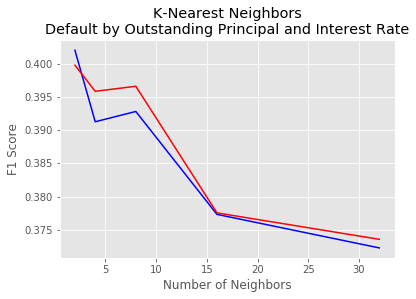

In [54]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.plot(n_neighbors, train_results, c='blue', label='Training Set')
ax.plot(n_neighbors, test_results, c='red', label='Training Set')
ax.set(title='K-Nearest Neighbors\nDefault by Outstanding Principal and Interest Rate',
       xlabel="Number of Neighbors", ylabel="F1 Score")
plt.show()

Our best KNN is one with 2 neighbors. Let's check out a visual of this for funzies.

## Random Forest

We did some great work with our logistic regression modeling, but let's see if we can obtain a little more accuracy with a random forest.

In [45]:
features = ['dti', 'int_rate', 'emp_length', 'home_ownership', 'purpose',
            'delinq_2yrs','revol_bal', 'loan_amnt', 'grade', 'term', 'installment', 'addr_state']
model_name = 'Random Forest'
X, y = df.loc[:, features], df.loc[:, dependent]
rf = RandomForestClassifier()
pipeline = clf_pipeline(rf, features, degree)
log_clf_model(results, pipeline, model_name, X, y, features, degree=1)

In [47]:
features = ['dti', 'int_rate', 'emp_length', 'home_ownership', 'purpose',
            'delinq_2yrs','revol_bal', 'loan_amnt', 'grade', 'term', 'installment', 'addr_state']
model_name = 'Random Forest with class weights'
X, y = df.loc[:, features], df.loc[:, dependent]
rf = RandomForestClassifier(class_weight='balanced')
pipeline = clf_pipeline(rf, features, degree)
log_clf_model(results, pipeline, model_name, X, y, features, degree=1)

In [48]:
(results_to_df(results)
 .pipe(scores_formatted)
 .head(10))

,model_type,features,degree,train_accuracy,test_accuracy,precision,recall,f1_score,true_negatives,false_positives,false_negatives,true_positives
5,Random Forest with class weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term, ...",1,97.60%,77.13%,41.58%,11.58%,18.12%,"39,655","1,890","10,266","1,345"
4,Random Forest,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term, ...",1,97.71%,76.86%,40.22%,12.23%,18.76%,"39,434","2,111","10,191","1,420"
0,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term]",3,35.91%,36.02%,22.38%,78.12%,34.79%,"10,079","31,466","2,541","9,070"
1,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term, ...",2,33.59%,33.98%,23.55%,90.02%,37.33%,"7,610","33,935","1,159","10,452"
2,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term, ...",3,31.37%,31.59%,22.87%,89.87%,36.47%,"6,359","35,186","1,176","10,435"
3,Logistic Regression with Class Weights,"[dti, int_rate, emp_length, home_ownership, purpose, delinq_2yrs, revol_bal, loan_amnt, grade, term, ...",3,31.37%,31.59%,22.87%,89.87%,36.47%,"6,359","35,186","1,176","10,435"
